# Gestructureerde data

In deze notebook gaan we het klassieke Titanic classificatieprobleem oplossen.
In het eerste deel gaan we dit met pytorch doen, in het tweede deel met keras en tensorflow.

Hierbij worden de volgende stappen uitgevoerd:
- Data inladen
- Data Modelling
- Model evaluation

De dataset die we hierbij gebruiken kan als volgt gedownload worden:

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define URL to load the Titanic dataset
url = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"

# Load the dataset into a Pandas DataFrame
df_orig = pd.read_csv(url)

# Display the first few rows of the dataset
df_orig.head()


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Deze data kan dan als volgt gepreprocessed worden

In [2]:
df = df_orig.copy()

# Handle missing data: Fill missing values with the median (for numerical data) or mode (for categorical data)
age_mean = df['age'].median()
df['age'].fillna(age_mean, inplace=True)
df['embark_town'].fillna("unknown", inplace=True)

# Encode categorical variables
df['sex'] = LabelEncoder().fit_transform(df['sex'])
df['class'] = LabelEncoder().fit_transform(df['class'])
df['embark_town'] = LabelEncoder().fit_transform(df['embark_town'])
df['alone'] = LabelEncoder().fit_transform(df['alone'])
df = pd.concat([df, pd.get_dummies(df['deck'], dtype=int)],axis=1)
df = df.drop('deck', axis=1)

# Split features and target
X = df.drop(columns=['survived'])
y = df['survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/tmp/ipykernel_3034/1785128422.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_mean, inplace=True)
/tmp/ipykernel_3034/1785128422.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [3]:
X_train.shape

(501, 16)

## Modelling met pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cpu')

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Feed-Forward Neural Network model in PyTorch
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()   # sigmoid activatiefunctie zodat er een kans uitkomt

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Instantiate the model, define the loss function and optimizer
model = TitanicModel()
criterion = nn.BCELoss() # als er een sigmoid activatiefunctie is (indien lineaire activatiefunctie gebruik BCEWithLogitsLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model with Early Stopping
early_stopping_tolerance = 5
min_loss = np.inf
patience = 0

for epoch in range(100):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # squeeze laat dimensies met maar 1 kanaal weg (32,1) -> (32)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss/len(test_loader)}")

    # Early Stopping
    if val_loss < min_loss:
        min_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience >= early_stopping_tolerance:
            print("Early stopping")
            break


Epoch 1, Training Loss: 0.6823542341589928, Validation Loss: 0.6672932058572769
Epoch 2, Training Loss: 0.6593259572982788, Validation Loss: 0.6399343758821487
Epoch 3, Training Loss: 0.633420355618, Validation Loss: 0.6072706431150436
Epoch 4, Training Loss: 0.602263804525137, Validation Loss: 0.5666180849075317
Epoch 5, Training Loss: 0.5667950063943863, Validation Loss: 0.5235695764422417
Epoch 6, Training Loss: 0.5244724992662668, Validation Loss: 0.4847450405359268
Epoch 7, Training Loss: 0.4898748751729727, Validation Loss: 0.452940434217453
Epoch 8, Training Loss: 0.4643250722438097, Validation Loss: 0.43384765088558197
Epoch 9, Training Loss: 0.43967819958925247, Validation Loss: 0.4276444911956787
Epoch 10, Training Loss: 0.42792466655373573, Validation Loss: 0.42727719247341156
Epoch 11, Training Loss: 0.41727731190621853, Validation Loss: 0.42859630286693573
Epoch 12, Training Loss: 0.40998216066509485, Validation Loss: 0.4269583746790886
Epoch 13, Training Loss: 0.406135327

Hieronder staat de code om een visuele weergave van het model te bekomen

In [5]:
import torch
from torchviz import make_dot

# Gebruik een voorbeeldinput om het computationele grafiek te genereren
example_input = torch.randn(1, 16)  # A batch of 1, with 7 features (assuming 7 input features)
output = model(example_input)

# Maak een visualisatie van het computationele grafiek
make_dot(output, params=dict(model.named_parameters())).render("model_structure", format="png")

'model_structure.png'

In [6]:
from torchsummary import summary


summary(model, input_size=(16,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             544
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 16]             528
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
           Sigmoid-6                    [-1, 1]               0
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Tensorflow implementation

2024-08-29 08:30:55.621973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 08:30:55.915706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 08:30:56.033768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 08:30:56.067711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 08:30:56.285400: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1724920259.312016      20 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 08:30:59.313107: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5711 - loss: 0.6770 - val_accuracy: 0.6733 - val_loss: 0.6336
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7175 - loss: 0.6317 - val_accuracy: 0.7327 - val_loss: 0.5976
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7645 - loss: 0.5831 - val_accuracy: 0.7228 - val_loss: 0.5705
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.5504 - val_accuracy: 0.7624 - val_loss: 0.5460
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7811 - loss: 0.5339 - val_accuracy: 0.7921 - val_loss: 0.5198
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8143 - loss: 0.5016 - val_accuracy: 0.7921 - val_loss: 0.5016
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7969 - loss: 0.5009 - val_accuracy: 0.8020 - val_loss: 0.4809
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8335 - loss: 0.4413 - val_accuracy: 0.8317 - val_loss: 0.

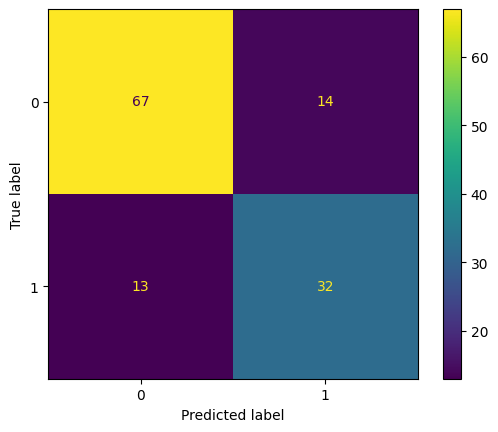

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define the Feed-Forward Neural Network model in TensorFlow
model_tf = models.Sequential([
    layers.InputLayer(input_shape=(16,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for Early Stopping and TensorBoard
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

# Train the model with Early Stopping and TensorBoard callbacks
history = model_tf.fit(X_train, y_train, validation_split=0.2, epochs=100, 
                       callbacks=[early_stopping_cb, tensorboard_cb], batch_size=32)

# Evaluate the model
loss, accuracy = model_tf.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Create predictions for the confusion matrix
y_pred_tf = (model_tf.predict(X_test) > 0.5).astype("int32")

# Plot the confusion matrix
cm_tf = confusion_matrix(y_test, y_pred_tf)
disp_tf = ConfusionMatrixDisplay(confusion_matrix=cm_tf)
disp_tf.plot()
plt.show()

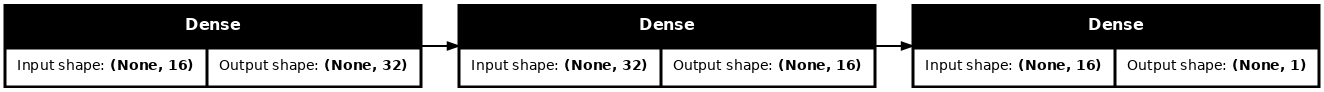

In [9]:
# teken de graaf van dit preprocessing model
tf.keras.utils.plot_model(model = model_tf , rankdir="LR", dpi=72, show_shapes=True)

In [10]:
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,269 (12.77 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,180 (8.52 KB)

## Tensorflow met preprocessing in het netwerk

Hierboven werd het preprocessing gedeelte nog gedaan met sci-kit learn.
Het kan beter zijn voor productie om de (sommige) preprocessing mee te betrekken in het neuraal netwerk.
Dit om te voorkomen dat je alle preprocessingstappen moet beschikbaar maken voor developers die het op dezelfde manier moeten implementeren.
Hierdoor kan je soms data vrijgeven (zoals gemiddelden voor scalers, woordenboeken voor categorieke data, ...) wat niet gewenst is.

In [21]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [38]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Normalization, StringLookup, CategoryEncoding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Split into features and labels
target = "survived"
features = df_orig.copy()
labels = features.pop(target)

# Identify categorical and numerical columns
categorical_columns = ['sex', 'class', 'deck', 'embark_town', 'alone']
numerical_columns = ['age', 'n_siblings_spouses', 'parch', 'fare']

# Create Input layers and preprocessing layers
inputs = {}
preprocessed_inputs = []

# Process numerical features
for col in numerical_columns:
    input_col = Input(shape=(1,), name=col)
    # Create a Normalization layer and adapt it to the data
    normalization_layer = Normalization()
    normalization_layer.adapt(features[col].values.reshape(-1, 1))
    normalized_col = normalization_layer(input_col)
    inputs[col] = input_col
    preprocessed_inputs.append(normalized_col)

# Process categorical features
for col in categorical_columns:
    input_col = Input(shape=(1,), name=col, dtype=tf.string)
    # Create a StringLookup layer and adapt it to the data
    lookup_layer = StringLookup(output_mode='int')  # output_mode='int' for one-hot encoding
    lookup_layer.adapt(features[col])
    encoded_col = lookup_layer(input_col)
    # One-hot encode the integer categorical indices
    one_hot_layer = CategoryEncoding(num_tokens=lookup_layer.vocabulary_size(), output_mode='one_hot')
    one_hot_col = one_hot_layer(encoded_col)
    inputs[col] = input_col
    preprocessed_inputs.append(one_hot_col)

# Concatenate all preprocessed inputs
all_features = Concatenate()(preprocessed_inputs)

# Define the neural network model
x = Dense(128, activation='relu')(all_features)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Convert the DataFrame to a dictionary of NumPy arrays
features_dict = {name: tf.convert_to_tensor(features[name].values) for name in features.columns}

# Train the model
model.fit(x=features_dict, y=labels, epochs=10, validation_split=0.2)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sex (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deck (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embark_town         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alone (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ n_siblings_spouses  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parch (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fare (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_87    │ (None, 1)         │          0 │ sex[0][0]         │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_88    │ (None, 1)         │          0 │ class[0][0]       │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_89    │ (None, 1)         │          0 │ deck[0][0]        │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_90    │ (None, 1)         │          0 │ embark_town[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_91    │ (None, 1)         │          0 │ alone[0][0]       │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_76    │ (None, 1)         │          3 │ age[0][0]         │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_77    │ (None, 1)         │          3 │ n_siblings_spous… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_78    │ (None, 1)         │          3 │ parch[0][0]       │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_79    │ (None, 1)         │          3 │ fare[0][0]        │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_… │ (None, 3)         │          0 │ string_lookup_87… │
│ (CategoryEncoding)  │                   │            │                 

 Total params: 12,045 (47.07 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 12 (64.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6663 - loss: 0.6535 - val_accuracy: 0.8651 - val_loss: 0.4955
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7657 - loss: 0.5407 - val_accuracy: 0.8889 - val_loss: 0.3907
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8013 - loss: 0.4874 - val_accuracy: 0.8730 - val_loss: 0.3488
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8021 - loss: 0.4413 - val_accuracy: 0.8810 - val_loss: 0.3245
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8131 - loss: 0.4235 - val_accuracy: 0.8889 - val_loss: 0.3194
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8188 - loss: 0.4163 - val_accuracy: 0.8889 - val_loss: 0.3115
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 0.4140 - val_accuracy: 0.8730 - val_loss: 0.3164
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8026 - loss: 0.4274 - val_accuracy: 0.8730 - val_loss

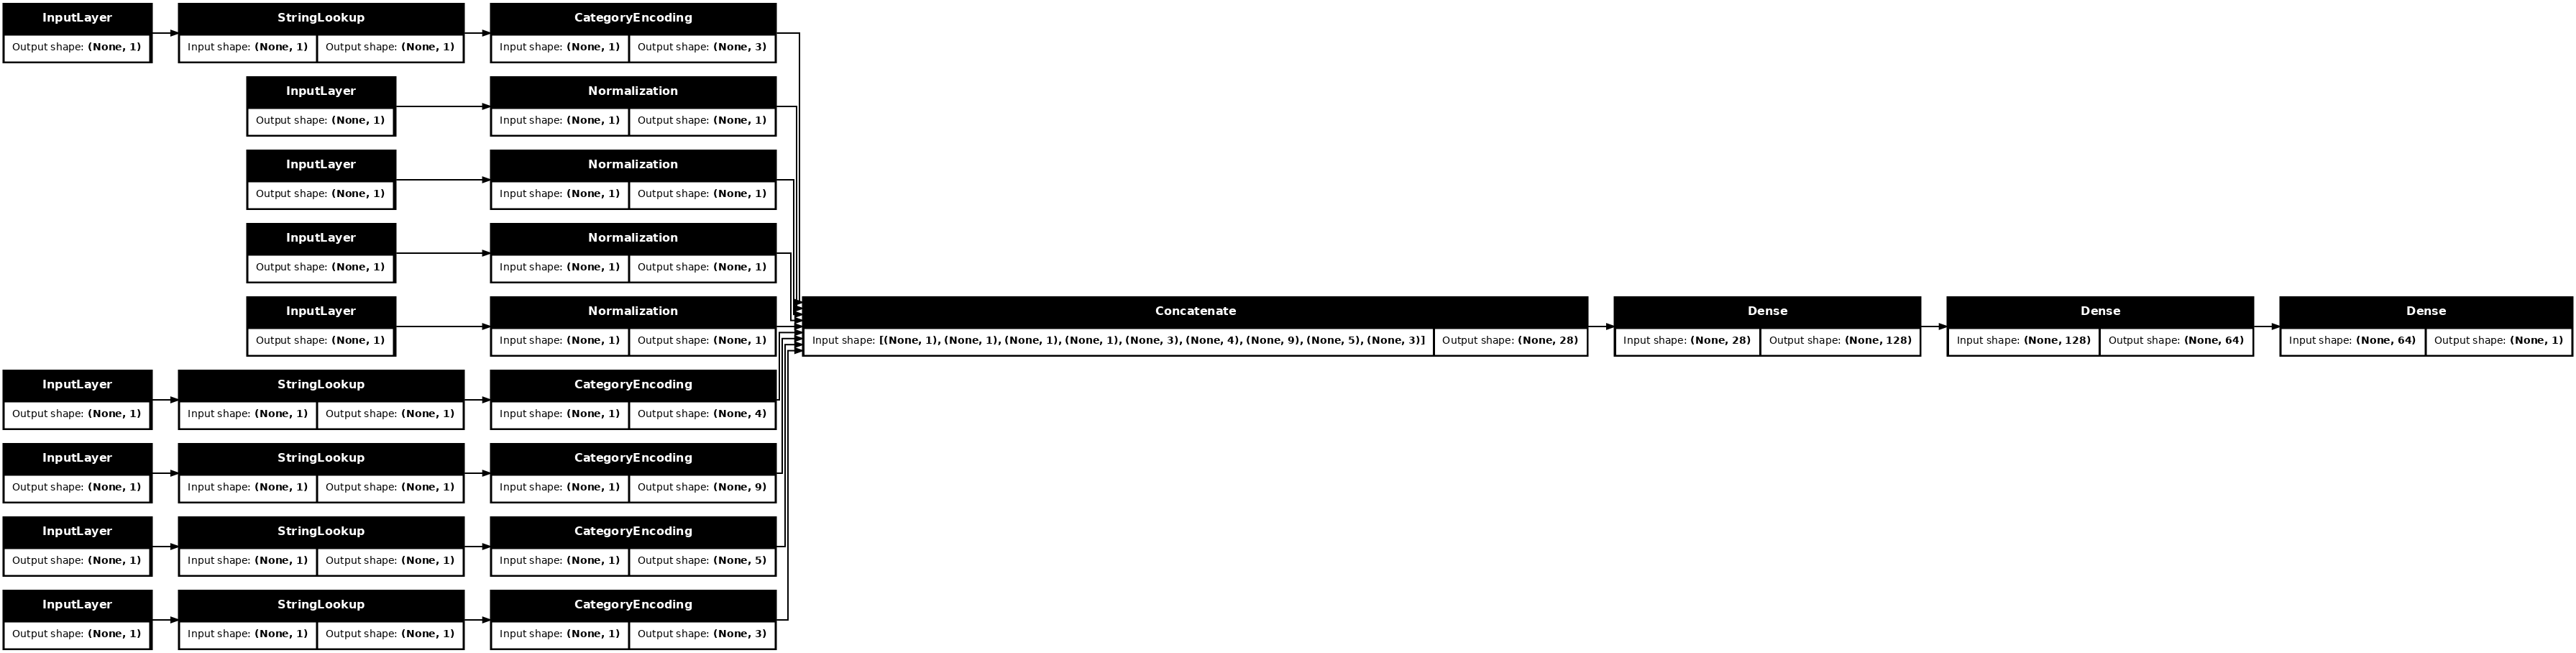

In [36]:
# teken de graaf van dit preprocessing model
tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=72, show_shapes=True)

In [46]:
from tensorflow.keras.layers import Lambda

# deze funtie kan gebruikt worden om concatenatie van kolommen te doen die op dezelfde manier moeten verwerkt worden
# hiermee kan het aantal nodige layers beperkt worden (1 normalization layer ipv 1 per input bvb) 
def stack_dict(inputs, dtype=tf.float32):
    # Use Keras Lambda layer to stack tensors
    return Lambda(lambda x: tf.stack([tf.cast(x[k], dtype) for k in sorted(x.keys())], axis=-1))(inputs)

In [68]:
# Create Input layers for all features
inputs = {}
for col in numerical_columns + categorical_columns:
    if col in categorical_columns:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[col] = Input(shape=(1,), name=col, dtype=dtype)

# Concatenate numerical inputs
numerical_inputs = [inputs[col] for col in numerical_columns]
numerical_concatenated = Concatenate()(numerical_inputs)

# Create and adapt the normalization layer for all numerical columns
normalization_layer = Normalization()
normalization_layer.adapt(tf.convert_to_tensor(features[numerical_columns].values))
normalized_numerical = normalization_layer(numerical_concatenated)

# Concatenate categorical inputs
categorical_inputs = [inputs[col] for col in categorical_columns]
categorical_concatenated = Concatenate()(categorical_inputs)

# Process all categorical features using a single StringLookup and CategoryEncoding layer
lookup_layer = StringLookup(output_mode='int')
lookup_layer.adapt(tf.convert_to_tensor(features[categorical_columns].values.flatten()))  # Flatten to use a single lookup layer
encoded_categorical = lookup_layer(categorical_concatenated)

# One-hot encode the integer categorical indices (anders gaat het niet werken)
one_hot_layer = CategoryEncoding(num_tokens=lookup_layer.vocabulary_size(), output_mode='multi_hot')
one_hot_categorical = one_hot_layer(encoded_categorical)

# Concatenate all preprocessed inputs
all_features = Concatenate()([normalized_numerical, one_hot_categorical])

# Define the neural network model
x = Dense(128, activation='relu')(all_features)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
model.fit(x=features_dict, y=labels, epochs=10, validation_split=0.2)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sex (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deck (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embark_town         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alone (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ n_siblings_spouses  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parch (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fare (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_51      │ (None, 5)         │          0 │ sex[0][0],        │
│ (Concatenate)       │                   │            │ class[0][0],      │
│                     │                   │            │ deck[0][0],       │
│                     │                   │            │ embark_town[0][0… │
│                     │                   │            │ alone[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_50      │ (None, 4)         │          0 │ age[0][0],        │
│ (Concatenate)       │                   │            │ n_siblings_spous… │
│                     │                   │            │ parch[0][0],      │
│                     │                   │            │ fare[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_103   │ (None, 5)         │          0 │ concatenate_51[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_92    │ (None, 4)         │          9 │ concatenate_50[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_… │ (None, 19)        │          0 │ string_lookup_10… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 23)        │          0 │ normalization_92… │
│ (Concatenate)       │                   │            │ category_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │      3,072 │ concatenate_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 64)        │      8,256 │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1)         │         65 │ dense_63[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 11,402 (44.54 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 9 (40.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6582 - loss: 0.6397 - val_accuracy: 0.8254 - val_loss: 0.4937
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7567 - loss: 0.5372 - val_accuracy: 0.8968 - val_loss: 0.3913
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7796 - loss: 0.4973 - val_accuracy: 0.8571 - val_loss: 0.3498
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.4542 - val_accuracy: 0.8571 - val_loss: 0.3246
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.4331 - val_accuracy: 0.8651 - val_loss: 0.3134
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8386 - loss: 0.3964 - val_accuracy: 0.8730 - val_loss: 0.3450
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8065 - loss: 0.4358 - val_accuracy: 0.8730 - val_loss: 0.3144
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8174 - loss: 0.4140 - val_accuracy: 0.8730 - val_loss

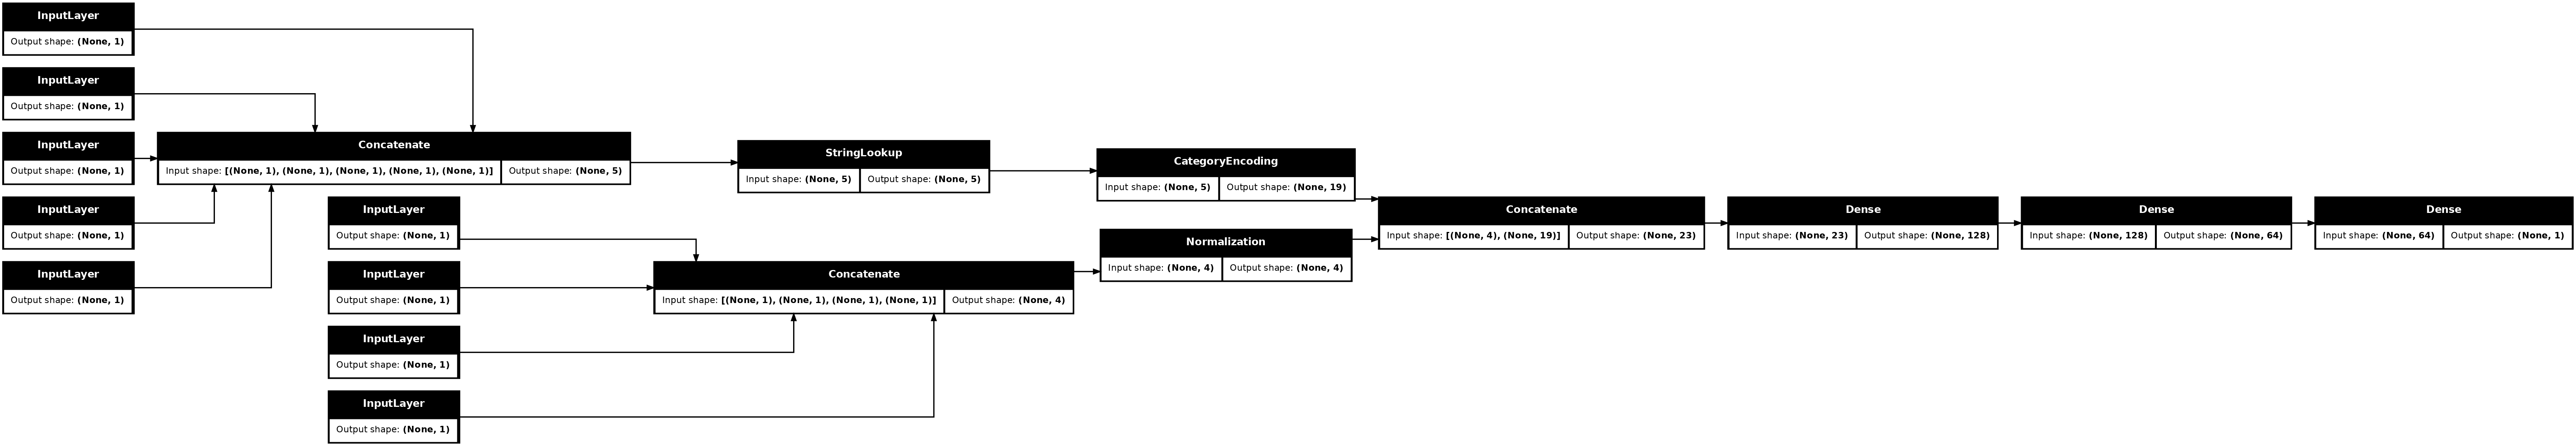

In [70]:
# teken de graaf van dit preprocessing model
tf.keras.utils.plot_model(model = model , rankdir="LR", dpi=120, show_shapes=True)